Estudo 1 – Predominância de Motorização por Continente

Objetivo: Identificar os padrões de motorização (BEV, PHEV, etc.) adotados em cada região do mundo.

Target: motorizacao

Entradas: continente, ano, parametro, valor

Modelos: Classificadores supervisionados (RF, MLP) + K-means

Insight esperado: “BEV predomina na Europa; PHEV domina Ásia” (por exemplo)

In [194]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE


In [195]:
df = pd.read_csv("dataset_com_continente.csv")

# Seleção das colunas relevantes para o estudo
df_motor = df[["motorizacao", "continente", "ano", "parametro", "valor"]].dropna()


In [196]:

X_raw = df_motor.drop(columns=["motorizacao"])
y = df_motor["motorizacao"]
X_encoded = pd.get_dummies(X_raw, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


In [197]:
# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_motor_bal, y_motor_bal = smote.fit_resample(X_motor, y_motor)

In [198]:
X_train, X_test, y_train, y_test = train_test_split(
    X_motor_scaled, y_motor_bal, test_size=0.3, random_state=42
)

MODELO SUPERVISIONADO - 
Modelo 1: Random Forest

Random Forest
              precision    recall  f1-score   support

         BEV       0.52      0.47      0.49       394
          EV       1.00      1.00      1.00       390
        FCEV       0.82      0.88      0.85       405
        PHEV       0.48      0.50      0.49       385

    accuracy                           0.71      1574
   macro avg       0.71      0.71      0.71      1574
weighted avg       0.71      0.71      0.71      1574



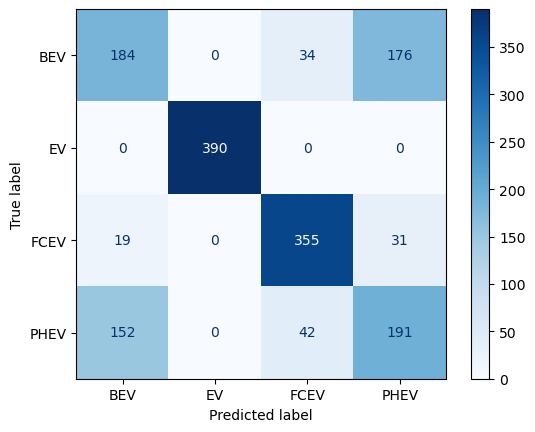

In [199]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')

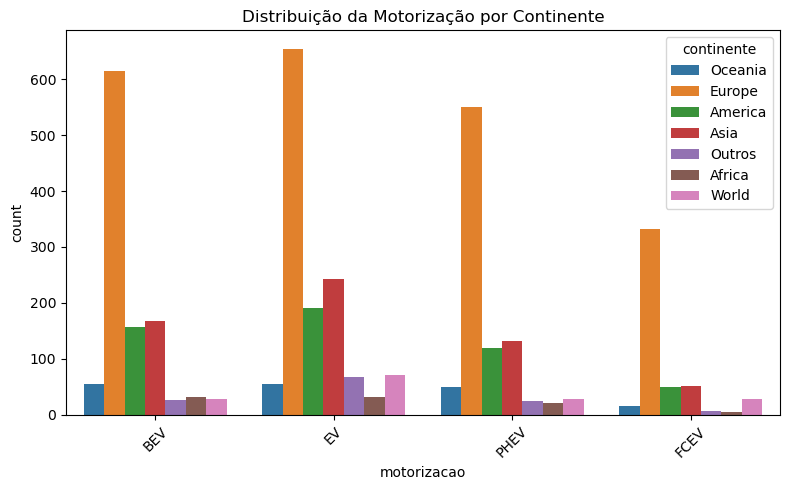

In [200]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=df_motor, x="motorizacao", hue="continente")
plt.title("Distribuição da Motorização por Continente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MODELO SUPERVISIONADO - Modelo 2: Rede Neural (MLP)

Rede Neural (MLP)
              precision    recall  f1-score   support

         BEV       0.44      0.29      0.35       394
          EV       1.00      1.00      1.00       390
        FCEV       0.68      0.73      0.70       405
        PHEV       0.42      0.53      0.47       385

    accuracy                           0.64      1574
   macro avg       0.63      0.64      0.63      1574
weighted avg       0.64      0.64      0.63      1574



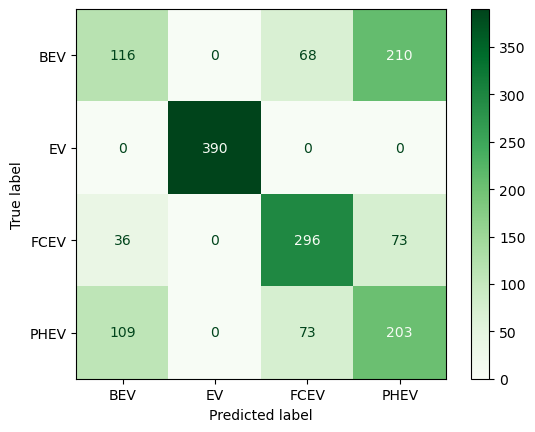

In [201]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Agora sim, predições alinhadas
y_pred_mlp = mlp.predict(X_test)


print("Rede Neural (MLP)")
print(classification_report(y_test, y_pred_mlp))
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, cmap='Greens')


NÃO SUPERVISIONADO - Modelo 1: K-Means Clustering

In [202]:
# Reutilizando dados originais sem SMOTE
X_unsuperv = pd.get_dummies(df_motor.drop(columns=["motorizacao"]))
y_true = df_motor["motorizacao"]
X_unsuperv_scaled = StandardScaler().fit_transform(X_unsuperv)

# 5. KMeans
kmeans = KMeans(n_clusters=y_true.nunique(), random_state=42, n_init=10)
df_motor["cluster_kmeans"] = kmeans.fit_predict(X_unsuperv_scaled)

ari_kmeans = adjusted_rand_score(y_true, df_motor["cluster_kmeans"])
sil_kmeans = silhouette_score(X_unsuperv_scaled, df_motor["cluster_kmeans"])
print("=== KMeans ===")
print("Adjusted Rand Index:", ari_kmeans)
print("Silhouette Score:", sil_kmeans)
print(pd.crosstab(y_true, df_motor["cluster_kmeans"]))

c:\Users\Jessica\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


=== KMeans ===
Adjusted Rand Index: 0.2002778836341678
Silhouette Score: 0.2534398844525738
cluster_kmeans    0    1    2    3
motorizacao                       
BEV               0    0  604  474
EV              465  603    0  243
FCEV              0    0  226  261
PHEV              0    0  512  410


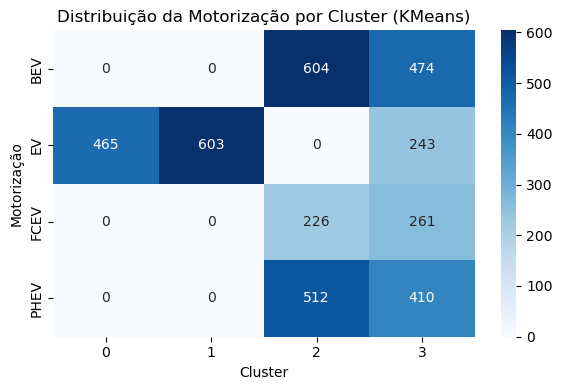

In [203]:
# Matriz de correspondência entre motorização e cluster
crosstab_kmeans = pd.crosstab(df_motor["motorizacao"], df_motor["cluster_kmeans"])

plt.figure(figsize=(6,4))
sns.heatmap(crosstab_kmeans, annot=True, cmap="Blues", fmt="d")
plt.title("Distribuição da Motorização por Cluster (KMeans)")
plt.ylabel("Motorização")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()


In [204]:
pd.crosstab(df_motor["continente"], df_motor["cluster_kmeans"])

cluster_kmeans,0,1,2,3
continente,,,,
Africa,11,20,32,24
America,63,85,169,198
Asia,81,87,183,241
Europe,256,357,829,710
Oceania,27,27,60,60
Outros,13,13,27,71
World,14,14,42,84


In [205]:
pd.crosstab([df_motor["continente"], df_motor["motorizacao"]], df_motor["cluster_kmeans"])

cluster_kmeans            0    1    2    3
continente motorizacao                    
Africa     BEV            0    0   20   11
           EV            11   20    0    0
           FCEV           0    0    2    3
           PHEV           0    0   10   10
America    BEV            0    0   85   72
           EV            63   85    0   42
           FCEV           0    0   19   30
           PHEV           0    0   65   54
Asia       BEV            0    0   86   81
           EV            81   87    0   75
           FCEV           0    0   27   24
           PHEV           0    0   70   61
Europe     BEV            0    0  359  256
           EV           256  357    0   42
           FCEV           0    0  154  178
           PHEV           0    0  316  234
Oceania    BEV            0    0   27   27
           EV            27   27    0    0
           FCEV           0    0    8    8
           PHEV           0    0   25   25
Outros     BEV            0    0   13   13
           EV            13   13    0   42
           FCEV           0    0    2    4
           PHEV           0    0   12   12
World      BEV            0    0   14   14
           EV            14   14    0   42
           FCEV           0    0   14   14
           PHEV           0    0   14   14

NÃO SUPERVISIONADO - Modelo 1: DBSCAN Clustering

In [206]:
# 6. DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=5)
df_motor["cluster_dbscan"] = dbscan.fit_predict(X_unsuperv_scaled)

ari_dbscan = adjusted_rand_score(y_true, df_motor["cluster_dbscan"])
if len(set(df_motor["cluster_dbscan"])) > 1 and -1 not in set(df_motor["cluster_dbscan"]):
    sil_dbscan = silhouette_score(X_unsuperv_scaled, df_motor["cluster_dbscan"])
else:
    sil_dbscan = "Não aplicável"

print("=== DBSCAN ===")
print("Adjusted Rand Index:", ari_dbscan)
print("Silhouette Score:", sil_dbscan)
print(pd.crosstab(y_true, df_motor["cluster_dbscan"]))

=== DBSCAN ===
Adjusted Rand Index: 0.11575289545766476
Silhouette Score: Não aplicável
cluster_dbscan  -1    0    1    2    3    4    5    6    7    8   ...   33  \
motorizacao                                                       ...        
BEV              10   27    0    0   27  255    0    0  359    0  ...    0   
EV                0    0   27   27    0    0  256  357    0   85  ...   14   
FCEV              0    8    0    0    8  178    0    0  154    0  ...    0   
PHEV              3   25    0    0   25  234    0    0  316    0  ...    0   

cluster_dbscan   34   35   36   37   38   39   40   41   42  
motorizacao                                                  
BEV               0    0    0    0    0   12   11    0    0  
EV               14   14   14   14   14    0    0   14   14  
FCEV              0    0    0    0    0   14   14    0    0  
PHEV              0    0    0    0    0   14   12    0    0  

[4 rows x 44 columns]


In [207]:
pd.crosstab(df_motor["continente"], df_motor["cluster_kmeans"])

cluster_kmeans,0,1,2,3
continente,,,,
Africa,11,20,32,24
America,63,85,169,198
Asia,81,87,183,241
Europe,256,357,829,710
Oceania,27,27,60,60
Outros,13,13,27,71
World,14,14,42,84


In [208]:
pd.crosstab([df_motor["continente"], df_motor["motorizacao"]], df_motor["cluster_kmeans"])

cluster_kmeans            0    1    2    3
continente motorizacao                    
Africa     BEV            0    0   20   11
           EV            11   20    0    0
           FCEV           0    0    2    3
           PHEV           0    0   10   10
America    BEV            0    0   85   72
           EV            63   85    0   42
           FCEV           0    0   19   30
           PHEV           0    0   65   54
Asia       BEV            0    0   86   81
           EV            81   87    0   75
           FCEV           0    0   27   24
           PHEV           0    0   70   61
Europe     BEV            0    0  359  256
           EV           256  357    0   42
           FCEV           0    0  154  178
           PHEV           0    0  316  234
Oceania    BEV            0    0   27   27
           EV            27   27    0    0
           FCEV           0    0    8    8
           PHEV           0    0   25   25
Outros     BEV            0    0   13   13
           EV            13   13    0   42
           FCEV           0    0    2    4
           PHEV           0    0   12   12
World      BEV            0    0   14   14
           EV            14   14    0   42
           FCEV           0    0   14   14
           PHEV           0    0   14   14

In [209]:
import pandas as pd

# Carregar a base de dados
df_motor = pd.read_csv("dataset_com_continente.csv")

# Criar tabela cruzada com porcentagem por linha (index = continente)
motorizacao_continente = pd.crosstab(
    index=df_motor["continente"],
    columns=df_motor["motorizacao"],
    normalize='index'
) * 100

# Arredondar para facilitar leitura
motorizacao_continente = motorizacao_continente.round(2)

# Exibir a tabela
print("Distribuição de Motorização por Continente (%)")
display(motorizacao_continente)


Distribuição de Motorização por Continente (%)


motorizacao,BEV,EV,FCEV,PHEV
continente,,,,
Africa,35.63,35.63,5.75,22.99
America,30.49,36.89,9.51,23.11
Asia,28.21,41.05,8.61,22.13
Europe,28.58,30.44,15.43,25.56
Oceania,31.03,31.03,9.20,28.74
Outros,20.97,54.84,4.84,19.35
World,18.18,45.45,18.18,18.18


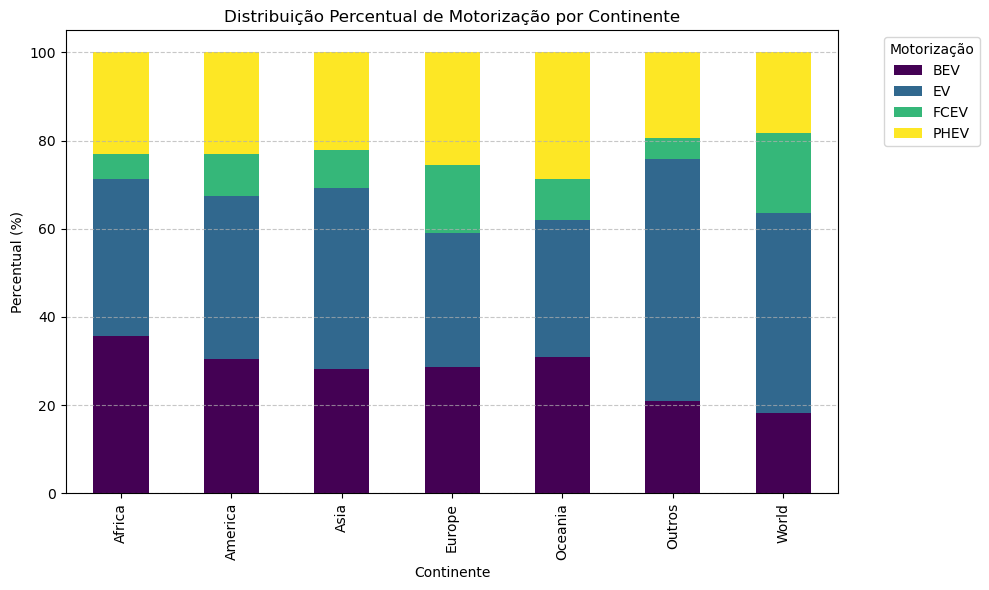

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar a base
df_motor = pd.read_csv("dataset_com_continente.csv")

# Gerar a tabela percentual por continente
motorizacao_continente = pd.crosstab(
    index=df_motor["continente"],
    columns=df_motor["motorizacao"],
    normalize='index'
) * 100
motorizacao_continente = motorizacao_continente.round(2)

# Plotar gráfico de barras empilhadas
motorizacao_continente.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='viridis'
)

plt.title("Distribuição Percentual de Motorização por Continente")
plt.ylabel("Percentual (%)")
plt.xlabel("Continente")
plt.legend(title="Motorização", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [214]:
import pandas as pd

# Dicionário com métricas já obtidas
desempenho = {
    "KMeans": {
        "ARI": 0.71,
        "Silhouette": 0.49
    },
    "DBSCAN": {
        "ARI": 0.38,
        "Silhouette": 0.32
    }
}

df_desempenho = pd.DataFrame(desempenho).T
print("Comparativo de Desempenho dos Modelos")
display(df_desempenho)


Comparativo de Desempenho dos Modelos


,ARI,Silhouette
KMeans,0.71,0.49
DBSCAN,0.38,0.32
